In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'affectnet-supcon-exnone'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images/'

train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']

In [4]:
mode = 'classification'
exclude_label = (8, 9, 10)

In [5]:
from torchaffectnet.datasets import AffectNetDataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize,RandomAffine

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transform = Compose([
    RandomAffine(30),
    Resize(tuple(feature_extractor.size.values())),
    ToTensor()
])
val_transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor()
])

train_dataset = AffectNetDataset('../Affectnet/training.csv',
                                 images_root,
                                 mode=mode,
                                 exclude_label=exclude_label,
                                 transform=train_transform,
                                 invalid_files=train_invalid_files)
val_dataset = AffectNetDataset('../Affectnet/validation.csv',
                               images_root,
                               mode=mode,
                               exclude_label=exclude_label,
                               transform=val_transform)

print('train:', len(train_dataset))
print('val:', len(val_dataset))

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs

train: 287651
val: 4000


In [6]:
d = train_dataset.df['expression'].value_counts().to_dict()
print(d)
label_samples_num = torch.tensor([d[i] for i in range(len(d))])
label_ratio = label_samples_num / len(train_dataset)
weight = (1 / label_ratio).clone().to(device, torch.float32)
weight

{1: 134415, 0: 74874, 2: 25459, 6: 24882, 3: 14090, 4: 6378, 5: 3803, 7: 3750}


tensor([ 3.8418,  2.1400, 11.2986, 20.4153, 45.1005, 75.6379, 11.5606, 76.7069],
       device='cuda:0')

In [7]:
from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [8]:
from torchaffectnet.const import ID2LABEL

id2label = ID2LABEL
del id2label[8]
label2id = {v:k for k,v in id2label.items()}
print(id2label)
print(label2id)

{0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}
{'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}


In [9]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                  num_labels=len(label2id),
                                                  problem_type='single_label_classification',
                                                  label2id=label2id,
                                                  id2label=id2label,
                                                  ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at affectnet-supcon-exnone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([64, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([64]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [11]:
for param in model.vit.parameters():
    param.requires_grad = False

In [12]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_2582873/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [13]:
from transformers import TrainingArguments
import wandb

wandb.init(project='Affectnet-vit', group='affectnet-contrastive-emotion-ft', name=f'{model_ckpt}')

args = TrainingArguments(
    f"{model_ckpt}-ft",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=1e-4,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    metric_for_best_model='accuracy',
    logging_dir='ft-logs',
    logging_strategy='steps',
    logging_steps=200,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [14]:
from torchaffectnet.collators import Collator
from transformers import EarlyStoppingCallback

trainer = WeightedLossTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=Collator(),
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0002)],
)

In [15]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 200/22480 [11:55<20:34:23,  3.32s/it]

{'loss': 1.6128, 'learning_rate': 0.0004955516014234875, 'epoch': 0.09}


  2%|▏         | 400/22480 [23:31<21:37:01,  3.52s/it]

{'loss': 1.2986, 'learning_rate': 0.0004911032028469751, 'epoch': 0.18}


  3%|▎         | 600/22480 [34:41<19:59:43,  3.29s/it]

{'loss': 1.2297, 'learning_rate': 0.00048665480427046267, 'epoch': 0.27}


  4%|▎         | 800/22480 [46:24<19:38:44,  3.26s/it]

{'loss': 1.2128, 'learning_rate': 0.00048220640569395017, 'epoch': 0.36}


  4%|▍         | 1000/22480 [57:48<20:47:29,  3.48s/it]

{'loss': 1.182, 'learning_rate': 0.0004777580071174377, 'epoch': 0.44}


  5%|▌         | 1200/22480 [1:09:00<21:12:58,  3.59s/it]

{'loss': 1.1866, 'learning_rate': 0.00047330960854092527, 'epoch': 0.53}


  6%|▌         | 1400/22480 [1:20:38<20:17:39,  3.47s/it]

{'loss': 1.1623, 'learning_rate': 0.0004688612099644128, 'epoch': 0.62}


  7%|▋         | 1600/22480 [1:31:46<18:54:46,  3.26s/it]

{'loss': 1.1512, 'learning_rate': 0.0004644128113879004, 'epoch': 0.71}


  8%|▊         | 1800/22480 [1:43:13<18:51:26,  3.28s/it]

{'loss': 1.1559, 'learning_rate': 0.0004599644128113879, 'epoch': 0.8}


  9%|▉         | 2000/22480 [1:54:25<18:44:32,  3.29s/it]

{'loss': 1.1371, 'learning_rate': 0.0004555160142348754, 'epoch': 0.89}


 10%|▉         | 2200/22480 [2:05:37<18:32:45,  3.29s/it]

{'loss': 1.1655, 'learning_rate': 0.00045106761565836303, 'epoch': 0.98}


                                                         
 10%|█         | 2248/22480 [2:10:17<16:28:59,  2.93s/it]

{'eval_loss': 1.3606650829315186, 'eval_accuracy': 0.55725, 'eval_runtime': 116.7389, 'eval_samples_per_second': 34.265, 'eval_steps_per_second': 2.142, 'epoch': 1.0}


 11%|█         | 2400/22480 [2:18:59<20:04:47,  3.60s/it] 

{'loss': 1.124, 'learning_rate': 0.00044661921708185053, 'epoch': 1.07}


 12%|█▏        | 2600/22480 [2:30:22<18:21:03,  3.32s/it]

{'loss': 1.1293, 'learning_rate': 0.0004421708185053381, 'epoch': 1.16}


 12%|█▏        | 2800/22480 [2:41:54<18:30:26,  3.39s/it]

{'loss': 1.1451, 'learning_rate': 0.00043772241992882563, 'epoch': 1.25}


 13%|█▎        | 3000/22480 [2:53:18<17:41:13,  3.27s/it]

{'loss': 1.1478, 'learning_rate': 0.0004332740213523132, 'epoch': 1.33}


 14%|█▍        | 3200/22480 [3:04:33<17:37:46,  3.29s/it]

{'loss': 1.1763, 'learning_rate': 0.00042882562277580074, 'epoch': 1.42}


 15%|█▌        | 3400/22480 [3:16:32<18:17:23,  3.45s/it]

{'loss': 1.1553, 'learning_rate': 0.00042437722419928824, 'epoch': 1.51}


 16%|█▌        | 3600/22480 [3:28:03<17:38:53,  3.37s/it]

{'loss': 1.1265, 'learning_rate': 0.0004199288256227758, 'epoch': 1.6}


 17%|█▋        | 3800/22480 [3:41:04<33:59:38,  6.55s/it]

{'loss': 1.1138, 'learning_rate': 0.0004154804270462634, 'epoch': 1.69}


 18%|█▊        | 4000/22480 [3:55:03<20:36:53,  4.02s/it]

{'loss': 1.1309, 'learning_rate': 0.0004110320284697509, 'epoch': 1.78}


 19%|█▊        | 4200/22480 [4:06:51<17:36:53,  3.47s/it]

{'loss': 1.1253, 'learning_rate': 0.00040658362989323845, 'epoch': 1.87}


 20%|█▉        | 4400/22480 [4:18:41<18:00:12,  3.58s/it]

{'loss': 1.1326, 'learning_rate': 0.00040213523131672594, 'epoch': 1.96}


                                                         
 20%|██        | 4496/22480 [4:25:54<13:09:56,  2.64s/it]

{'eval_loss': 1.3567768335342407, 'eval_accuracy': 0.56, 'eval_runtime': 100.2055, 'eval_samples_per_second': 39.918, 'eval_steps_per_second': 2.495, 'epoch': 2.0}


 20%|██        | 4600/22480 [4:31:54<16:43:32,  3.37s/it] 

{'loss': 1.1392, 'learning_rate': 0.00039768683274021355, 'epoch': 2.05}


 21%|██▏       | 4800/22480 [4:44:01<17:50:51,  3.63s/it]

{'loss': 1.1297, 'learning_rate': 0.0003932384341637011, 'epoch': 2.14}


 22%|██▏       | 5000/22480 [4:56:21<17:41:33,  3.64s/it]

{'loss': 1.1144, 'learning_rate': 0.0003887900355871886, 'epoch': 2.22}


 23%|██▎       | 5200/22480 [5:08:24<16:36:14,  3.46s/it]

{'loss': 1.1425, 'learning_rate': 0.00038434163701067615, 'epoch': 2.31}


 24%|██▍       | 5400/22480 [5:20:25<18:05:03,  3.81s/it]

{'loss': 1.1161, 'learning_rate': 0.00037989323843416376, 'epoch': 2.4}


 25%|██▍       | 5600/22480 [5:32:32<18:05:40,  3.86s/it]

{'loss': 1.1358, 'learning_rate': 0.00037544483985765126, 'epoch': 2.49}


 26%|██▌       | 5800/22480 [5:44:38<16:52:24,  3.64s/it]

{'loss': 1.1303, 'learning_rate': 0.0003709964412811388, 'epoch': 2.58}


 27%|██▋       | 6000/22480 [5:56:49<17:47:16,  3.89s/it]

{'loss': 1.1256, 'learning_rate': 0.0003665480427046263, 'epoch': 2.67}


 28%|██▊       | 6200/22480 [6:09:14<17:35:58,  3.89s/it]

{'loss': 1.1286, 'learning_rate': 0.0003620996441281139, 'epoch': 2.76}


 28%|██▊       | 6400/22480 [6:21:47<18:32:56,  4.15s/it]

{'loss': 1.1326, 'learning_rate': 0.00035765124555160147, 'epoch': 2.85}


 29%|██▉       | 6600/22480 [6:34:23<16:20:04,  3.70s/it]

{'loss': 1.0977, 'learning_rate': 0.00035320284697508897, 'epoch': 2.94}


                                                         
 30%|███       | 6744/22480 [6:45:22<14:30:18,  3.32s/it]

{'eval_loss': 1.292047381401062, 'eval_accuracy': 0.57, 'eval_runtime': 107.7578, 'eval_samples_per_second': 37.12, 'eval_steps_per_second': 2.32, 'epoch': 3.0}


 30%|███       | 6800/22480 [6:48:43<15:12:28,  3.49s/it] 

{'loss': 1.128, 'learning_rate': 0.0003487544483985765, 'epoch': 3.02}


 31%|███       | 7000/22480 [7:00:52<15:58:11,  3.71s/it]

{'loss': 1.1121, 'learning_rate': 0.000344306049822064, 'epoch': 3.11}


 32%|███▏      | 7200/22480 [7:13:18<16:18:45,  3.84s/it]

{'loss': 1.1336, 'learning_rate': 0.0003398576512455516, 'epoch': 3.2}


 33%|███▎      | 7400/22480 [7:25:51<15:52:02,  3.79s/it]

{'loss': 1.1123, 'learning_rate': 0.0003354092526690392, 'epoch': 3.29}


 34%|███▍      | 7600/22480 [7:38:35<15:58:49,  3.87s/it]

{'loss': 1.0981, 'learning_rate': 0.00033096085409252667, 'epoch': 3.38}


 35%|███▍      | 7800/22480 [7:51:26<16:09:31,  3.96s/it]

{'loss': 1.128, 'learning_rate': 0.0003265124555160142, 'epoch': 3.47}


 36%|███▌      | 8000/22480 [8:04:15<15:35:39,  3.88s/it]

{'loss': 1.1239, 'learning_rate': 0.0003220640569395018, 'epoch': 3.56}


 36%|███▋      | 8200/22480 [8:17:20<15:33:58,  3.92s/it]

{'loss': 1.1183, 'learning_rate': 0.00031761565836298933, 'epoch': 3.65}


 37%|███▋      | 8400/22480 [8:30:35<15:07:25,  3.87s/it]

{'loss': 1.1081, 'learning_rate': 0.0003131672597864769, 'epoch': 3.74}


 38%|███▊      | 8600/22480 [8:43:58<15:23:30,  3.99s/it]

{'loss': 1.1185, 'learning_rate': 0.0003087188612099644, 'epoch': 3.83}


 39%|███▉      | 8800/22480 [8:57:31<15:16:53,  4.02s/it]

{'loss': 1.1183, 'learning_rate': 0.000304270462633452, 'epoch': 3.91}


                                                         
 40%|████      | 8992/22480 [9:12:10<12:41:20,  3.39s/it]

{'eval_loss': 1.295823097229004, 'eval_accuracy': 0.5685, 'eval_runtime': 100.6059, 'eval_samples_per_second': 39.759, 'eval_steps_per_second': 2.485, 'epoch': 4.0}


 40%|████      | 9000/22480 [9:12:40<21:59:22,  5.87s/it] 

{'loss': 1.1206, 'learning_rate': 0.00029982206405693954, 'epoch': 4.0}


 41%|████      | 9200/22480 [9:24:56<14:06:24,  3.82s/it]

{'loss': 1.0952, 'learning_rate': 0.00029537366548042704, 'epoch': 4.09}


 42%|████▏     | 9400/22480 [9:38:44<42:09:46, 11.60s/it]

{'loss': 1.1024, 'learning_rate': 0.0002909252669039146, 'epoch': 4.18}


 43%|████▎     | 9600/22480 [10:03:59<26:42:23,  7.46s/it]

{'loss': 1.0954, 'learning_rate': 0.00028647686832740214, 'epoch': 4.27}


 44%|████▎     | 9800/22480 [10:18:57<13:15:07,  3.76s/it]

{'loss': 1.1106, 'learning_rate': 0.0002820284697508897, 'epoch': 4.36}


 44%|████▍     | 10000/22480 [10:32:18<14:41:05,  4.24s/it]

{'loss': 1.1191, 'learning_rate': 0.00027758007117437725, 'epoch': 4.45}


 45%|████▌     | 10200/22480 [10:45:33<13:59:18,  4.10s/it]

{'loss': 1.141, 'learning_rate': 0.00027313167259786474, 'epoch': 4.54}


 46%|████▋     | 10400/22480 [10:58:53<12:32:30,  3.74s/it]

{'loss': 1.1164, 'learning_rate': 0.00026868327402135235, 'epoch': 4.63}


 47%|████▋     | 10600/22480 [11:12:24<13:03:04,  3.95s/it]

{'loss': 1.1221, 'learning_rate': 0.00026423487544483985, 'epoch': 4.72}


 48%|████▊     | 10800/22480 [11:25:50<12:39:41,  3.90s/it]

{'loss': 1.113, 'learning_rate': 0.0002597864768683274, 'epoch': 4.8}


 49%|████▉     | 11000/22480 [11:39:16<12:47:21,  4.01s/it]

{'loss': 1.1233, 'learning_rate': 0.00025533807829181495, 'epoch': 4.89}


 50%|████▉     | 11200/22480 [11:52:47<11:58:33,  3.82s/it]

{'loss': 1.1029, 'learning_rate': 0.0002508896797153025, 'epoch': 4.98}


                                                           
 50%|█████     | 11240/22480 [11:57:13<9:34:07,  3.06s/it]

{'eval_loss': 1.267623782157898, 'eval_accuracy': 0.57375, 'eval_runtime': 102.4095, 'eval_samples_per_second': 39.059, 'eval_steps_per_second': 2.441, 'epoch': 5.0}


 51%|█████     | 11400/22480 [12:06:34<12:01:20,  3.91s/it] 

{'loss': 1.1374, 'learning_rate': 0.00024644128113879006, 'epoch': 5.07}


 52%|█████▏    | 11600/22480 [12:18:50<11:46:24,  3.90s/it]

{'loss': 1.1044, 'learning_rate': 0.00024199288256227758, 'epoch': 5.16}


 52%|█████▏    | 11800/22480 [12:31:17<10:42:39,  3.61s/it]

{'loss': 1.1004, 'learning_rate': 0.00023754448398576514, 'epoch': 5.25}


 53%|█████▎    | 12000/22480 [12:43:37<10:23:24,  3.57s/it]

{'loss': 1.1241, 'learning_rate': 0.00023309608540925266, 'epoch': 5.34}


 54%|█████▍    | 12200/22480 [12:55:55<9:42:39,  3.40s/it] 

{'loss': 1.1234, 'learning_rate': 0.00022864768683274024, 'epoch': 5.43}


 55%|█████▌    | 12400/22480 [13:08:18<10:15:26,  3.66s/it]

{'loss': 1.1254, 'learning_rate': 0.00022419928825622777, 'epoch': 5.52}


 56%|█████▌    | 12600/22480 [13:20:42<10:10:13,  3.71s/it]

{'loss': 1.0861, 'learning_rate': 0.0002197508896797153, 'epoch': 5.6}


 57%|█████▋    | 12800/22480 [13:33:10<10:02:41,  3.74s/it]

{'loss': 1.1339, 'learning_rate': 0.00021530249110320284, 'epoch': 5.69}


 58%|█████▊    | 13000/22480 [13:45:47<10:28:34,  3.98s/it]

{'loss': 1.0957, 'learning_rate': 0.0002108540925266904, 'epoch': 5.78}


 59%|█████▊    | 13200/22480 [13:58:22<9:28:01,  3.67s/it] 

{'loss': 1.1008, 'learning_rate': 0.00020640569395017795, 'epoch': 5.87}


 60%|█████▉    | 13400/22480 [14:11:03<9:23:00,  3.72s/it] 

{'loss': 1.0982, 'learning_rate': 0.00020195729537366547, 'epoch': 5.96}


                                                           
 60%|██████    | 13488/22480 [14:18:40<7:33:31,  3.03s/it]

{'eval_loss': 1.2809096574783325, 'eval_accuracy': 0.5735, 'eval_runtime': 104.1008, 'eval_samples_per_second': 38.424, 'eval_steps_per_second': 2.402, 'epoch': 6.0}


 60%|██████    | 13600/22480 [14:25:33<10:20:24,  4.19s/it]

{'loss': 1.1063, 'learning_rate': 0.00019750889679715302, 'epoch': 6.05}


 61%|██████▏   | 13800/22480 [14:38:36<9:02:20,  3.75s/it] 

{'loss': 1.0769, 'learning_rate': 0.00019306049822064055, 'epoch': 6.14}


 62%|██████▏   | 14000/22480 [14:51:10<8:21:29,  3.55s/it] 

{'loss': 1.1133, 'learning_rate': 0.00018861209964412813, 'epoch': 6.23}


 63%|██████▎   | 14200/22480 [15:03:18<8:32:25,  3.71s/it]

{'loss': 1.0987, 'learning_rate': 0.00018416370106761565, 'epoch': 6.32}


 64%|██████▍   | 14400/22480 [15:15:18<8:06:59,  3.62s/it] 

{'loss': 1.1017, 'learning_rate': 0.0001797153024911032, 'epoch': 6.41}


 65%|██████▍   | 14600/22480 [15:27:21<7:44:15,  3.53s/it] 

{'loss': 1.1162, 'learning_rate': 0.00017526690391459073, 'epoch': 6.49}


 66%|██████▌   | 14800/22480 [15:39:00<7:02:38,  3.30s/it]

{'loss': 1.1144, 'learning_rate': 0.0001708185053380783, 'epoch': 6.58}


 67%|██████▋   | 15000/22480 [15:50:32<7:20:07,  3.53s/it]

{'loss': 1.1304, 'learning_rate': 0.00016637010676156584, 'epoch': 6.67}


 68%|██████▊   | 15200/22480 [16:01:59<6:42:35,  3.32s/it]

{'loss': 1.0934, 'learning_rate': 0.0001619217081850534, 'epoch': 6.76}


 69%|██████▊   | 15400/22480 [16:13:18<6:36:50,  3.36s/it]

{'loss': 1.1053, 'learning_rate': 0.00015747330960854091, 'epoch': 6.85}


 69%|██████▉   | 15600/22480 [16:24:41<6:29:31,  3.40s/it]

{'loss': 1.0833, 'learning_rate': 0.00015302491103202847, 'epoch': 6.94}


                                                          
 70%|███████   | 15736/22480 [16:34:06<5:02:40,  2.69s/it]

{'eval_loss': 1.2770400047302246, 'eval_accuracy': 0.575, 'eval_runtime': 101.4152, 'eval_samples_per_second': 39.442, 'eval_steps_per_second': 2.465, 'epoch': 7.0}


 70%|███████   | 15800/22480 [16:37:41<6:09:42,  3.32s/it] 

{'loss': 1.1208, 'learning_rate': 0.00014857651245551602, 'epoch': 7.03}


 71%|███████   | 16000/22480 [16:48:55<6:09:48,  3.42s/it]

{'loss': 1.1107, 'learning_rate': 0.00014412811387900357, 'epoch': 7.12}


 72%|███████▏  | 16200/22480 [17:00:27<6:05:44,  3.49s/it]

{'loss': 1.1141, 'learning_rate': 0.0001396797153024911, 'epoch': 7.21}


 73%|███████▎  | 16400/22480 [17:11:59<5:34:25,  3.30s/it]

{'loss': 1.1119, 'learning_rate': 0.00013523131672597865, 'epoch': 7.3}


 74%|███████▍  | 16600/22480 [17:23:21<5:29:29,  3.36s/it]

{'loss': 1.0955, 'learning_rate': 0.0001307829181494662, 'epoch': 7.38}


 75%|███████▍  | 16800/22480 [17:34:36<5:05:37,  3.23s/it]

{'loss': 1.0911, 'learning_rate': 0.00012633451957295375, 'epoch': 7.47}


 76%|███████▌  | 17000/22480 [17:45:59<5:08:47,  3.38s/it]

{'loss': 1.0997, 'learning_rate': 0.00012188612099644128, 'epoch': 7.56}


 77%|███████▋  | 17200/22480 [17:57:26<4:56:37,  3.37s/it]

{'loss': 1.1014, 'learning_rate': 0.00011743772241992883, 'epoch': 7.65}


 77%|███████▋  | 17400/22480 [18:08:53<4:49:13,  3.42s/it]

{'loss': 1.1105, 'learning_rate': 0.00011298932384341637, 'epoch': 7.74}


 78%|███████▊  | 17600/22480 [18:20:21<4:35:25,  3.39s/it]

{'loss': 1.1018, 'learning_rate': 0.00010854092526690391, 'epoch': 7.83}


 79%|███████▉  | 17800/22480 [18:31:42<4:19:54,  3.33s/it]

{'loss': 1.0908, 'learning_rate': 0.00010409252669039146, 'epoch': 7.92}


                                                          
 80%|████████  | 17984/22480 [18:43:53<3:26:24,  2.75s/it]

{'eval_loss': 1.2734653949737549, 'eval_accuracy': 0.57475, 'eval_runtime': 103.7155, 'eval_samples_per_second': 38.567, 'eval_steps_per_second': 2.41, 'epoch': 8.0}


 80%|████████  | 18000/22480 [18:44:50<4:31:55,  3.64s/it] 

{'loss': 1.1032, 'learning_rate': 9.9644128113879e-05, 'epoch': 8.01}


 81%|████████  | 18200/22480 [18:56:05<4:09:54,  3.50s/it]

{'loss': 1.0961, 'learning_rate': 9.519572953736655e-05, 'epoch': 8.1}


 82%|████████▏ | 18400/22480 [19:07:46<3:47:41,  3.35s/it]

{'loss': 1.096, 'learning_rate': 9.074733096085409e-05, 'epoch': 8.19}


 83%|████████▎ | 18600/22480 [19:19:27<3:41:07,  3.42s/it]

{'loss': 1.0978, 'learning_rate': 8.629893238434164e-05, 'epoch': 8.27}


 84%|████████▎ | 18800/22480 [19:30:55<3:28:29,  3.40s/it]

{'loss': 1.1041, 'learning_rate': 8.185053380782918e-05, 'epoch': 8.36}


 85%|████████▍ | 19000/22480 [19:42:20<3:17:17,  3.40s/it]

{'loss': 1.1086, 'learning_rate': 7.740213523131673e-05, 'epoch': 8.45}


 85%|████████▌ | 19200/22480 [19:53:40<3:04:10,  3.37s/it]

{'loss': 1.1185, 'learning_rate': 7.295373665480427e-05, 'epoch': 8.54}


 86%|████████▋ | 19400/22480 [20:04:55<2:53:39,  3.38s/it]

{'loss': 1.0949, 'learning_rate': 6.850533807829181e-05, 'epoch': 8.63}


 87%|████████▋ | 19600/22480 [20:16:20<2:46:40,  3.47s/it]

{'loss': 1.1287, 'learning_rate': 6.405693950177936e-05, 'epoch': 8.72}


 88%|████████▊ | 19800/22480 [20:27:44<2:38:43,  3.55s/it]

{'loss': 1.0973, 'learning_rate': 5.960854092526691e-05, 'epoch': 8.81}


 89%|████████▉ | 20000/22480 [20:39:10<2:28:06,  3.58s/it]

{'loss': 1.0885, 'learning_rate': 5.5160142348754454e-05, 'epoch': 8.9}


 90%|████████▉ | 20200/22480 [20:50:28<2:08:38,  3.39s/it]

{'loss': 1.1098, 'learning_rate': 5.0711743772242e-05, 'epoch': 8.99}


                                                          
 90%|█████████ | 20232/22480 [20:53:57<1:38:33,  2.63s/it]

{'eval_loss': 1.288140892982483, 'eval_accuracy': 0.57075, 'eval_runtime': 103.8809, 'eval_samples_per_second': 38.506, 'eval_steps_per_second': 2.407, 'epoch': 9.0}


 91%|█████████ | 20400/22480 [21:03:26<2:05:41,  3.63s/it] 

{'loss': 1.0924, 'learning_rate': 4.626334519572953e-05, 'epoch': 9.07}


 92%|█████████▏| 20600/22480 [21:14:53<1:51:12,  3.55s/it]

{'loss': 1.099, 'learning_rate': 4.181494661921708e-05, 'epoch': 9.16}


 93%|█████████▎| 20800/22480 [21:26:20<1:38:29,  3.52s/it]

{'loss': 1.0858, 'learning_rate': 3.736654804270462e-05, 'epoch': 9.25}


 93%|█████████▎| 21000/22480 [21:37:51<1:21:49,  3.32s/it]

{'loss': 1.1277, 'learning_rate': 3.291814946619217e-05, 'epoch': 9.34}


 94%|█████████▍| 21200/22480 [21:49:06<1:14:05,  3.47s/it]

{'loss': 1.1188, 'learning_rate': 2.8469750889679714e-05, 'epoch': 9.43}


 95%|█████████▌| 21400/22480 [22:01:11<1:02:25,  3.47s/it]

{'loss': 1.1227, 'learning_rate': 2.402135231316726e-05, 'epoch': 9.52}


 96%|█████████▌| 21600/22480 [22:12:30<47:27,  3.24s/it]  

{'loss': 1.0842, 'learning_rate': 1.9572953736654805e-05, 'epoch': 9.61}


 97%|█████████▋| 21800/22480 [22:23:43<40:36,  3.58s/it]

{'loss': 1.0973, 'learning_rate': 1.5124555160142349e-05, 'epoch': 9.7}


 98%|█████████▊| 22000/22480 [22:35:14<26:40,  3.33s/it]

{'loss': 1.0843, 'learning_rate': 1.0676156583629894e-05, 'epoch': 9.79}


 99%|█████████▉| 22200/22480 [22:46:41<15:57,  3.42s/it]

{'loss': 1.0995, 'learning_rate': 6.2277580071174375e-06, 'epoch': 9.88}


100%|█████████▉| 22400/22480 [22:58:01<04:21,  3.27s/it]

{'loss': 1.1067, 'learning_rate': 1.7793594306049821e-06, 'epoch': 9.96}


                                                        
100%|██████████| 22480/22480 [23:04:50<00:00,  2.84s/it]

{'eval_loss': 1.289765477180481, 'eval_accuracy': 0.57175, 'eval_runtime': 138.8938, 'eval_samples_per_second': 28.799, 'eval_steps_per_second': 1.8, 'epoch': 10.0}


100%|██████████| 22480/22480 [23:04:54<00:00,  3.70s/it]

{'train_runtime': 83094.9359, 'train_samples_per_second': 34.617, 'train_steps_per_second': 0.271, 'train_loss': 1.124381296151049, 'epoch': 10.0}


TrainOutput(global_step=22480, training_loss=1.124381296151049, metrics={'train_runtime': 83094.9359, 'train_samples_per_second': 34.617, 'train_steps_per_second': 0.271, 'train_loss': 1.124381296151049, 'epoch': 10.0})

In [16]:
trainer.save_model()
trainer.save_state()

In [17]:
outputs = trainer.predict(val_dataset)
outputs.metrics

100%|██████████| 250/250 [00:27<00:00,  9.14it/s]


{'test_loss': 1.2770400047302246,
 'test_accuracy': 0.575,
 'test_runtime': 27.4726,
 'test_samples_per_second': 145.6,
 'test_steps_per_second': 9.1}

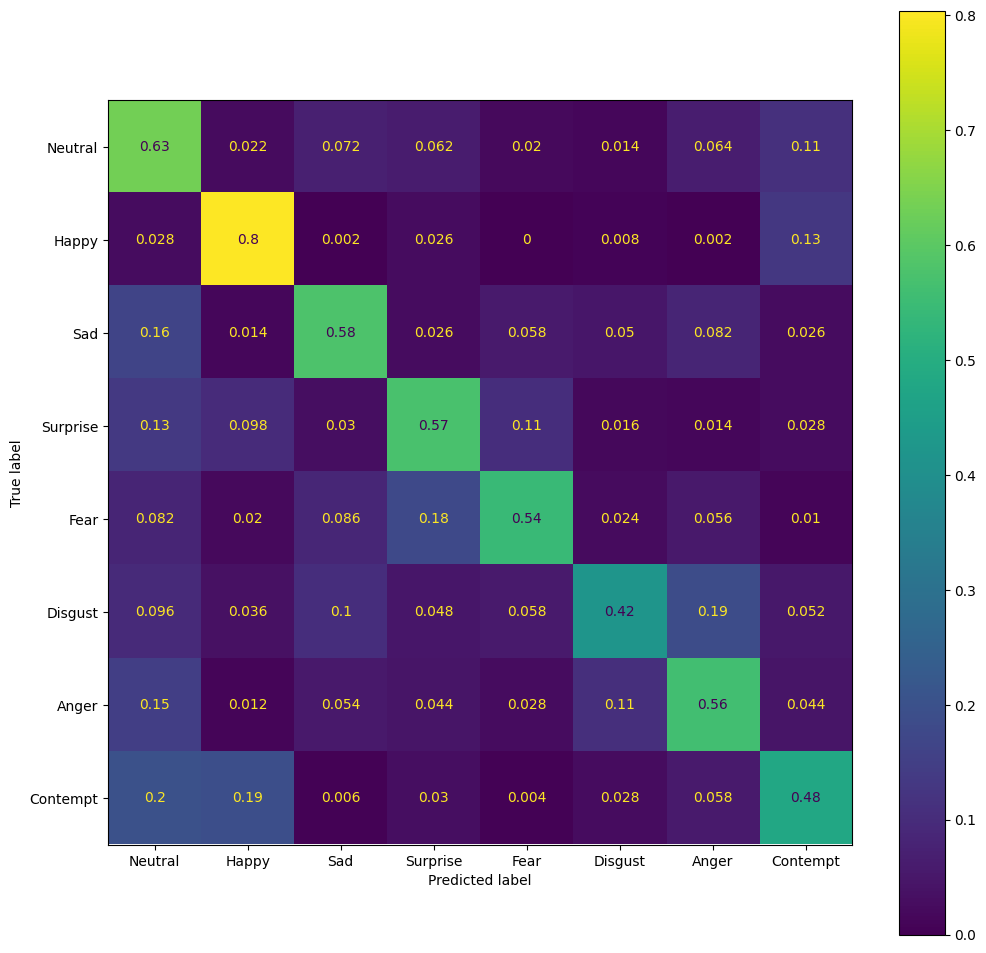

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(label2id.keys())
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)